## Training

In [1]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4, 5, 6, 7"

In [3]:
# Load the data
h5f = h5py.File('../CNN_experiments/data/data_cano_nearest_neighbor.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3011, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [4]:
from models import Squeeze_model

In [5]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# #plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [6]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*3
nb_epochs =100
l_rate = 1e-4

In [7]:
model_input = Input(shape=(28, 28, 28, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)

model.compile(optimizer=optimizers.adam(lr=l_rate),# beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')

In [8]:
from my_classes import AugmentedDataGeneratorRandom

In [9]:
rotation_count = 32
aug_data_gen = AugmentedDataGeneratorRandom(x=train_x, y=train_y, batch_size=nb_batch, rotation_count=rotation_count)
aug_val_gen = AugmentedDataGeneratorRandom(x=valid_x, y=valid_y, batch_size=nb_batch, rotation_count=rotation_count)

In [10]:
for x, y in aug_data_gen:
    print(x.shape, y.shape)
    break

(396, 28, 28, 28, 16) (396,)


In [11]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-cano_rotated_random_32.h5"

callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [12]:
history = model.fit_generator(generator=aug_data_gen, validation_data=aug_val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=5, 
                              workers=56, 
                              verbose=1, callbacks=callbacks_list)

Epoch 1/100
250/250 [==============================] - 548s 2s/step - loss: 2.0164 - val_loss: 1.5139

Epoch 00001: val_loss improved from inf to 1.51387, saving model to ./weights/weights-cano_rotated_random_32.h5
Epoch 2/100
250/250 [==============================] - 677s 3s/step - loss: 1.6095 - val_loss: 1.8074

Epoch 00002: val_loss did not improve from 1.51387
Epoch 3/100
250/250 [==============================] - 798s 3s/step - loss: 1.5350 - val_loss: 1.5235

Epoch 00003: val_loss did not improve from 1.51387
Epoch 4/100
250/250 [==============================] - 891s 4s/step - loss: 1.5718 - val_loss: 1.6508

Epoch 00004: val_loss did not improve from 1.51387
Epoch 5/100
250/250 [==============================] - 1036s 4s/step - loss: 1.5288 - val_loss: 1.6464

Epoch 00005: val_loss did not improve from 1.51387
Epoch 6/100
250/250 [==============================] - 1063s 4s/step - loss: 1.5461 - val_loss: 1.5513

Epoch 00006: val_loss did not improve from 1.51387
Epoch 7/100
2

250/250 [==============================] - 1979s 8s/step - loss: 1.3118 - val_loss: 1.3213

Epoch 00050: val_loss did not improve from 1.14672
Epoch 51/100
250/250 [==============================] - 2139s 9s/step - loss: 1.2728 - val_loss: 1.3693

Epoch 00051: val_loss did not improve from 1.14672
Epoch 52/100
250/250 [==============================] - 2097s 8s/step - loss: 1.3129 - val_loss: 1.3080

Epoch 00052: val_loss did not improve from 1.14672
Epoch 53/100
250/250 [==============================] - 2062s 8s/step - loss: 1.3125 - val_loss: 1.1773

Epoch 00053: val_loss did not improve from 1.14672
Epoch 54/100
250/250 [==============================] - 2121s 8s/step - loss: 1.2543 - val_loss: 1.3076

Epoch 00054: val_loss did not improve from 1.14672
Epoch 55/100
250/250 [==============================] - 1857s 7s/step - loss: 1.2597 - val_loss: 1.3525

Epoch 00055: val_loss did not improve from 1.14672
Epoch 56/100
250/250 [==============================] - 1789s 7s/step - loss:

In [13]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_cano_rotated_random.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

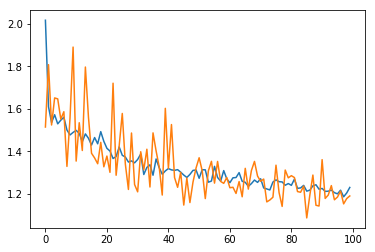

In [14]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [15]:
# Save the weights
model.load_weights(filepath)

In [16]:
from sklearn.metrics import r2_score

In [17]:
rotation_count = 32
sample_size = 200

In [18]:
train_aug_data_gen = AugmentedDataGeneratorRandom(x=train_x[:sample_size],
                                            y=train_y[:sample_size],
                                            batch_size=sample_size,
                                            rotation_count=rotation_count)

test_aug_data_gen = AugmentedDataGeneratorRandom(x=test_x[:sample_size],
                                            y=test_y[:sample_size],
                                            batch_size=sample_size,
                                            rotation_count=rotation_count)

In [19]:
# Train r2

for x, y in train_aug_data_gen:
    # Without average
    train_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Train r2 (without average): ", train_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*(rotation_count+1)
        end = i*(rotation_count+1) + (rotation_count+1)
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    train_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Train r2 (with average): ", train_r2)
    break

Train r2 (without average):  0.37973224957
Train r2 (with average):  0.39506870974


In [20]:
# Test r2

for x, y in test_aug_data_gen:
    # Without average
    test_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Test r2 (without average): ", test_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*(rotation_count+1)
        end = i*(rotation_count+1) + (rotation_count+1)
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    test_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Test r2 (with average): ", test_r2)
    break

Test r2 (without average):  0.446724034087
Test r2 (with average):  0.464771801514
